In [33]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


SEED = 42 # Muito importante manter a SEED igual em todos os modelos para garantir a consistência dos dados no ensemble
FOLDS = 5 # Muito importante manter o mesmo número de FOLDS em todos os modelos para garantir a consistência dos dados no ensemble

PATH = 'models/' # Caminho para os modelos
CLASSES = ["Enrolled","Graduate", "Dropout"]

scores = {} # Dicionário para armazenar os scores de estratégia de ensemble

# Listar todos os diretórios na pasta especificada
directories = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
individual_models = directories.copy()
print(directories)

['lgbm_1', 'xgb_1']


In [18]:
import numpy as np
import pandas as pd

class SoftVotingClassifier:
    def __init__(self, classifiers, classes):

        self.classifiers = classifiers
        self.classes = classes
        self.nclasses = len(classes)

    def fit(self, X, y):
        pass
    
    def predict(self, df):

        prob_sum = np.zeros((len(df), self.nclasses))

        self.classes_cols = []
        for i, classe in enumerate(self.classes):
            self.classes_cols.append([col for col in df.columns if col.endswith(classe)])
            prob_sum[:,i] = df[self.classes_cols[i]].sum(axis=1)

        # Normaliza as probabilidades somadas
        prob_sum /= len(self.classifiers)
        
        # Predição final é a classe com a maior probabilidade
        # predictions = self.classes[np.argmax(prob_sum, axis=1)]
        predictions = np.argmax(prob_sum, axis=1)
        
        return predictions


In [3]:
def build_dfs(directories):

    folds = []

    for i in range(FOLDS):

        models_predictions = []

        for model in directories:
            # Carregar o modelo
            df = pd.read_csv(f'{PATH}{model}/oof/fold_{i+1}.csv')
            columns = df.columns
            df.columns = [f'{model}_{col}' for col in columns]
            df.rename(columns={f'{model}_true': 'true_label'}, inplace=True)
            models_predictions.append(df)

        # Concatenar as previsões de todos os modelos
        df = pd.concat(models_predictions, axis=1)
        df = df.loc[:, ~df.columns.duplicated(keep='last')] # Remover colunas duplicadas(true label)
        folds.append(df)


    return folds

In [4]:
def cross_validation(model, folds, target_column='true_label', scoring=accuracy_score):
    scores = []
    
    for i, fold in enumerate(folds):
        print(f"Fold {i + 1}")
        
        # Separando o conjunto de treino e validação
        train_folds = folds[:i] + folds[i+1:]
        val_fold = fold
        
        # Concatenando os DataFrames de treino
        train_df = pd.concat(train_folds, ignore_index=True)
        
        # Separando as features e o target
        X_train = train_df.drop(columns=[target_column])
        y_train = train_df[target_column]
        
        X_val = val_fold.drop(columns=[target_column])
        y_val = val_fold[target_column]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões no conjunto de validação
        y_pred = model.predict(X_val)
        
        # Calculando a métrica de avaliação
        score = scoring(y_val, y_pred)
        scores.append(score)
                
    print(f"Score: {np.mean(scores)}")
    
    return scores

In [43]:
def summarize_models(scores, models, folds, encoder, scoring=accuracy_score):

    models_scores = {}
    
    for model in models:
        model_scores = []

        for fold in folds:
            model_cols = [col for col in fold.columns if col.startswith(model)]
            y_true = fold['true_label'].map(encoder)
            y_pred = fold[model_cols].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

            score = scoring(y_true, y_pred)
            model_scores.append(score)
        
        models_scores[model] = model_scores
    
    means = {key: np.mean(value) for key, value in scores.items()}

    print(scores.items())

    # Preparar dados para o gráfico
    keys = list(means.keys())
    values = list(means.values())

    # Plotar gráfico de barras
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Keys')
    plt.ylabel('Mean Values')
    plt.title('Mean of Arrays for Each Key')
    plt.show()

In [5]:
folds = build_dfs(directories)

In [37]:
for fold in folds:
    fold['true_label'] = fold['true_label'].replace({"Enrolled": 0, "Graduate": 1, "Dropout": 2})

encoder = {0: "Enrolled", 1: "Graduate", 2: "Dropout"}

In [46]:
logreg = LogisticRegression()

scores['logreg'] = cross_validation(logreg, folds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8329050177799211


In [47]:
xgb = XGBClassifier(random_state=42)

scores['xgb']  = cross_validation(xgb, folds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8308912398961349


In [48]:
svc = SoftVotingClassifier(directories, CLASSES)

scores['svc']  = cross_validation(svc, folds, scoring=accuracy_score)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8321143307443366


In [49]:
scores

{'logreg': [0.8340231021063685,
  0.8338377910927173,
  0.8322213985668396,
  0.8308005930318755,
  0.8336422041018038],
 'xgb': [0.8318611402804373,
  0.8311816665637161,
  0.8296268841116877,
  0.8299357548801581,
  0.8318507536446751],
 'svc': [0.8332818580517636,
  0.8327876953486936,
  0.83117123795404,
  0.830491722263405,
  0.8328391401037806]}

dict_items([('logreg', [0.8340231021063685, 0.8338377910927173, 0.8322213985668396, 0.8308005930318755, 0.8336422041018038]), ('xgb', [0.8318611402804373, 0.8311816665637161, 0.8296268841116877, 0.8299357548801581, 0.8318507536446751]), ('svc', [0.8332818580517636, 0.8327876953486936, 0.83117123795404, 0.830491722263405, 0.8328391401037806])])


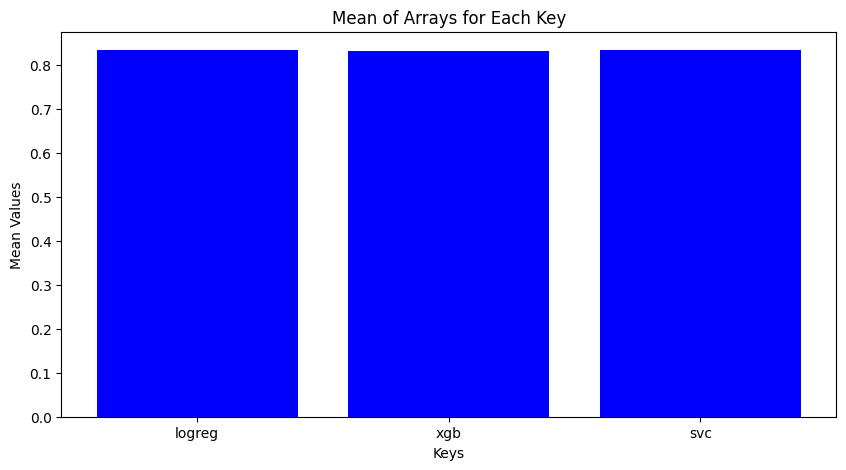

In [50]:
summarize_models(scores, individual_models, folds, encoder)